# Chapter 2 — Features and Representations  
## Part I — Foundations of Machine Learning

Covers standardization, pipelines, and feature transformations with a focus on interpretability and scaling behavior.

### 1. Setup and Feature Construction

In [1]:
# ==============================================================
# Feature Engineering for Predicting 1-Day Ahead Returns (NU ADR)
# ==============================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("../adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "NU"

# --- Basic Features ---
df["Return_1d"] = df[f"{ticker}_Price"].pct_change()
df["Vol_5d"] = df["Return_1d"].rolling(5).std()
df["MA_10"] = df[f"{ticker}_Price"].rolling(10).mean()
df["MA_20"] = df[f"{ticker}_Price"].rolling(20).mean()
df["MA_50"] = df[f"{ticker}_Price"].rolling(50).mean()
df["MA_ratio"] = df["MA_10"] / df["MA_50"] - 1

# --- Momentum Features ---
df["Mom_5d"] = df["Return_1d"].rolling(5).sum()
df["Mom_20d"] = df["Return_1d"].rolling(20).sum()

# --- Higher Moments ---
window = 20
df["Skew_20d"] = df["Return_1d"].rolling(window).apply(lambda x: skew(x, bias=False), raw=False)
df["Kurt_20d"] = df["Return_1d"].rolling(window).apply(lambda x: kurtosis(x, fisher=True, bias=False), raw=False)

# --- Volatility Ratios ---
df["Vol_20d"] = df["Return_1d"].rolling(20).std()
df["Vol_ratio"] = (df["Vol_5d"] / df["Vol_20d"].replace(0, np.nan)) - 1

# --- Trend / Mean-Reversion ---
df["Zscore_20d"] = (df[f"{ticker}_Price"] - df["MA_20"]) / df["Vol_20d"].replace(0, np.nan)
df["Trend_10_50"] = (df["MA_10"] > df["MA_50"]).astype(int)

# --- Liquidity (if available) ---
if f"{ticker}_Volume" in df.columns:
    df["Vol_Change_5d"] = df[f"{ticker}_Volume"].pct_change(5)
    df["Vol_SMA_ratio"] = (
        df[f"{ticker}_Volume"].rolling(5).mean() / df[f"{ticker}_Volume"].rolling(20).mean() - 1
    )

# --- RSI ---
delta = df[f"{ticker}_Price"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
rs = gain.rolling(14).mean() / loss.rolling(14).mean().replace(0, np.nan)
df["RSI_14"] = 100 - (100 / (1 + rs.replace([np.inf, -np.inf, 0], np.nan)))

# --- Target ---
df["Target"] = (df["Return_1d"].shift(-1) > 0).astype(int)

# --- Cleanup ---
df = df.replace([np.inf, -np.inf], np.nan).dropna().copy()

### 2. Feature Standardization (Z-Score)

In [2]:
# ==============================================================
# Feature Scaling (Standardization)
# ==============================================================

# --- Select Features ---
feature_cols = [
    "Return_1d", "Vol_5d", "MA_ratio", "Mom_5d", "Mom_20d",
    "Skew_20d", "Kurt_20d", "Vol_ratio", "RSI_14", "Trend_10_50"
]

X = df[feature_cols]

# --- Standardize Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Convert Back to DataFrame ---
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df.index)

# --- Quick Sanity Check ---
X_scaled.describe().round(3)

,Return_1d,Vol_5d,MA_ratio,Mom_5d,Mom_20d,Skew_20d,Kurt_20d,Vol_ratio,RSI_14,Trend_10_50
count,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000,53.000
mean,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000
std,1.010,1.010,1.010,1.010,1.010,1.010,1.010,1.010,1.010,1.010
min,-1.769,-1.407,-1.345,-2.008,-2.089,-1.268,-1.685,-2.082,-1.836,-1.592
25%,-0.632,-0.915,-0.638,-0.586,-0.905,-0.937,-0.791,-0.825,-0.933,-1.592
50%,-0.083,-0.365,-0.218,-0.015,0.284,-0.103,-0.085,0.023,0.262,0.628
75%,0.564,1.133,0.671,0.652,0.787,0.713,0.529,0.826,0.818,0.628
max,3.001,1.810,1.913,2.273,2.058,2.304,2.668,1.730,1.466,0.628


### 3. Pairwise Feature Relationships

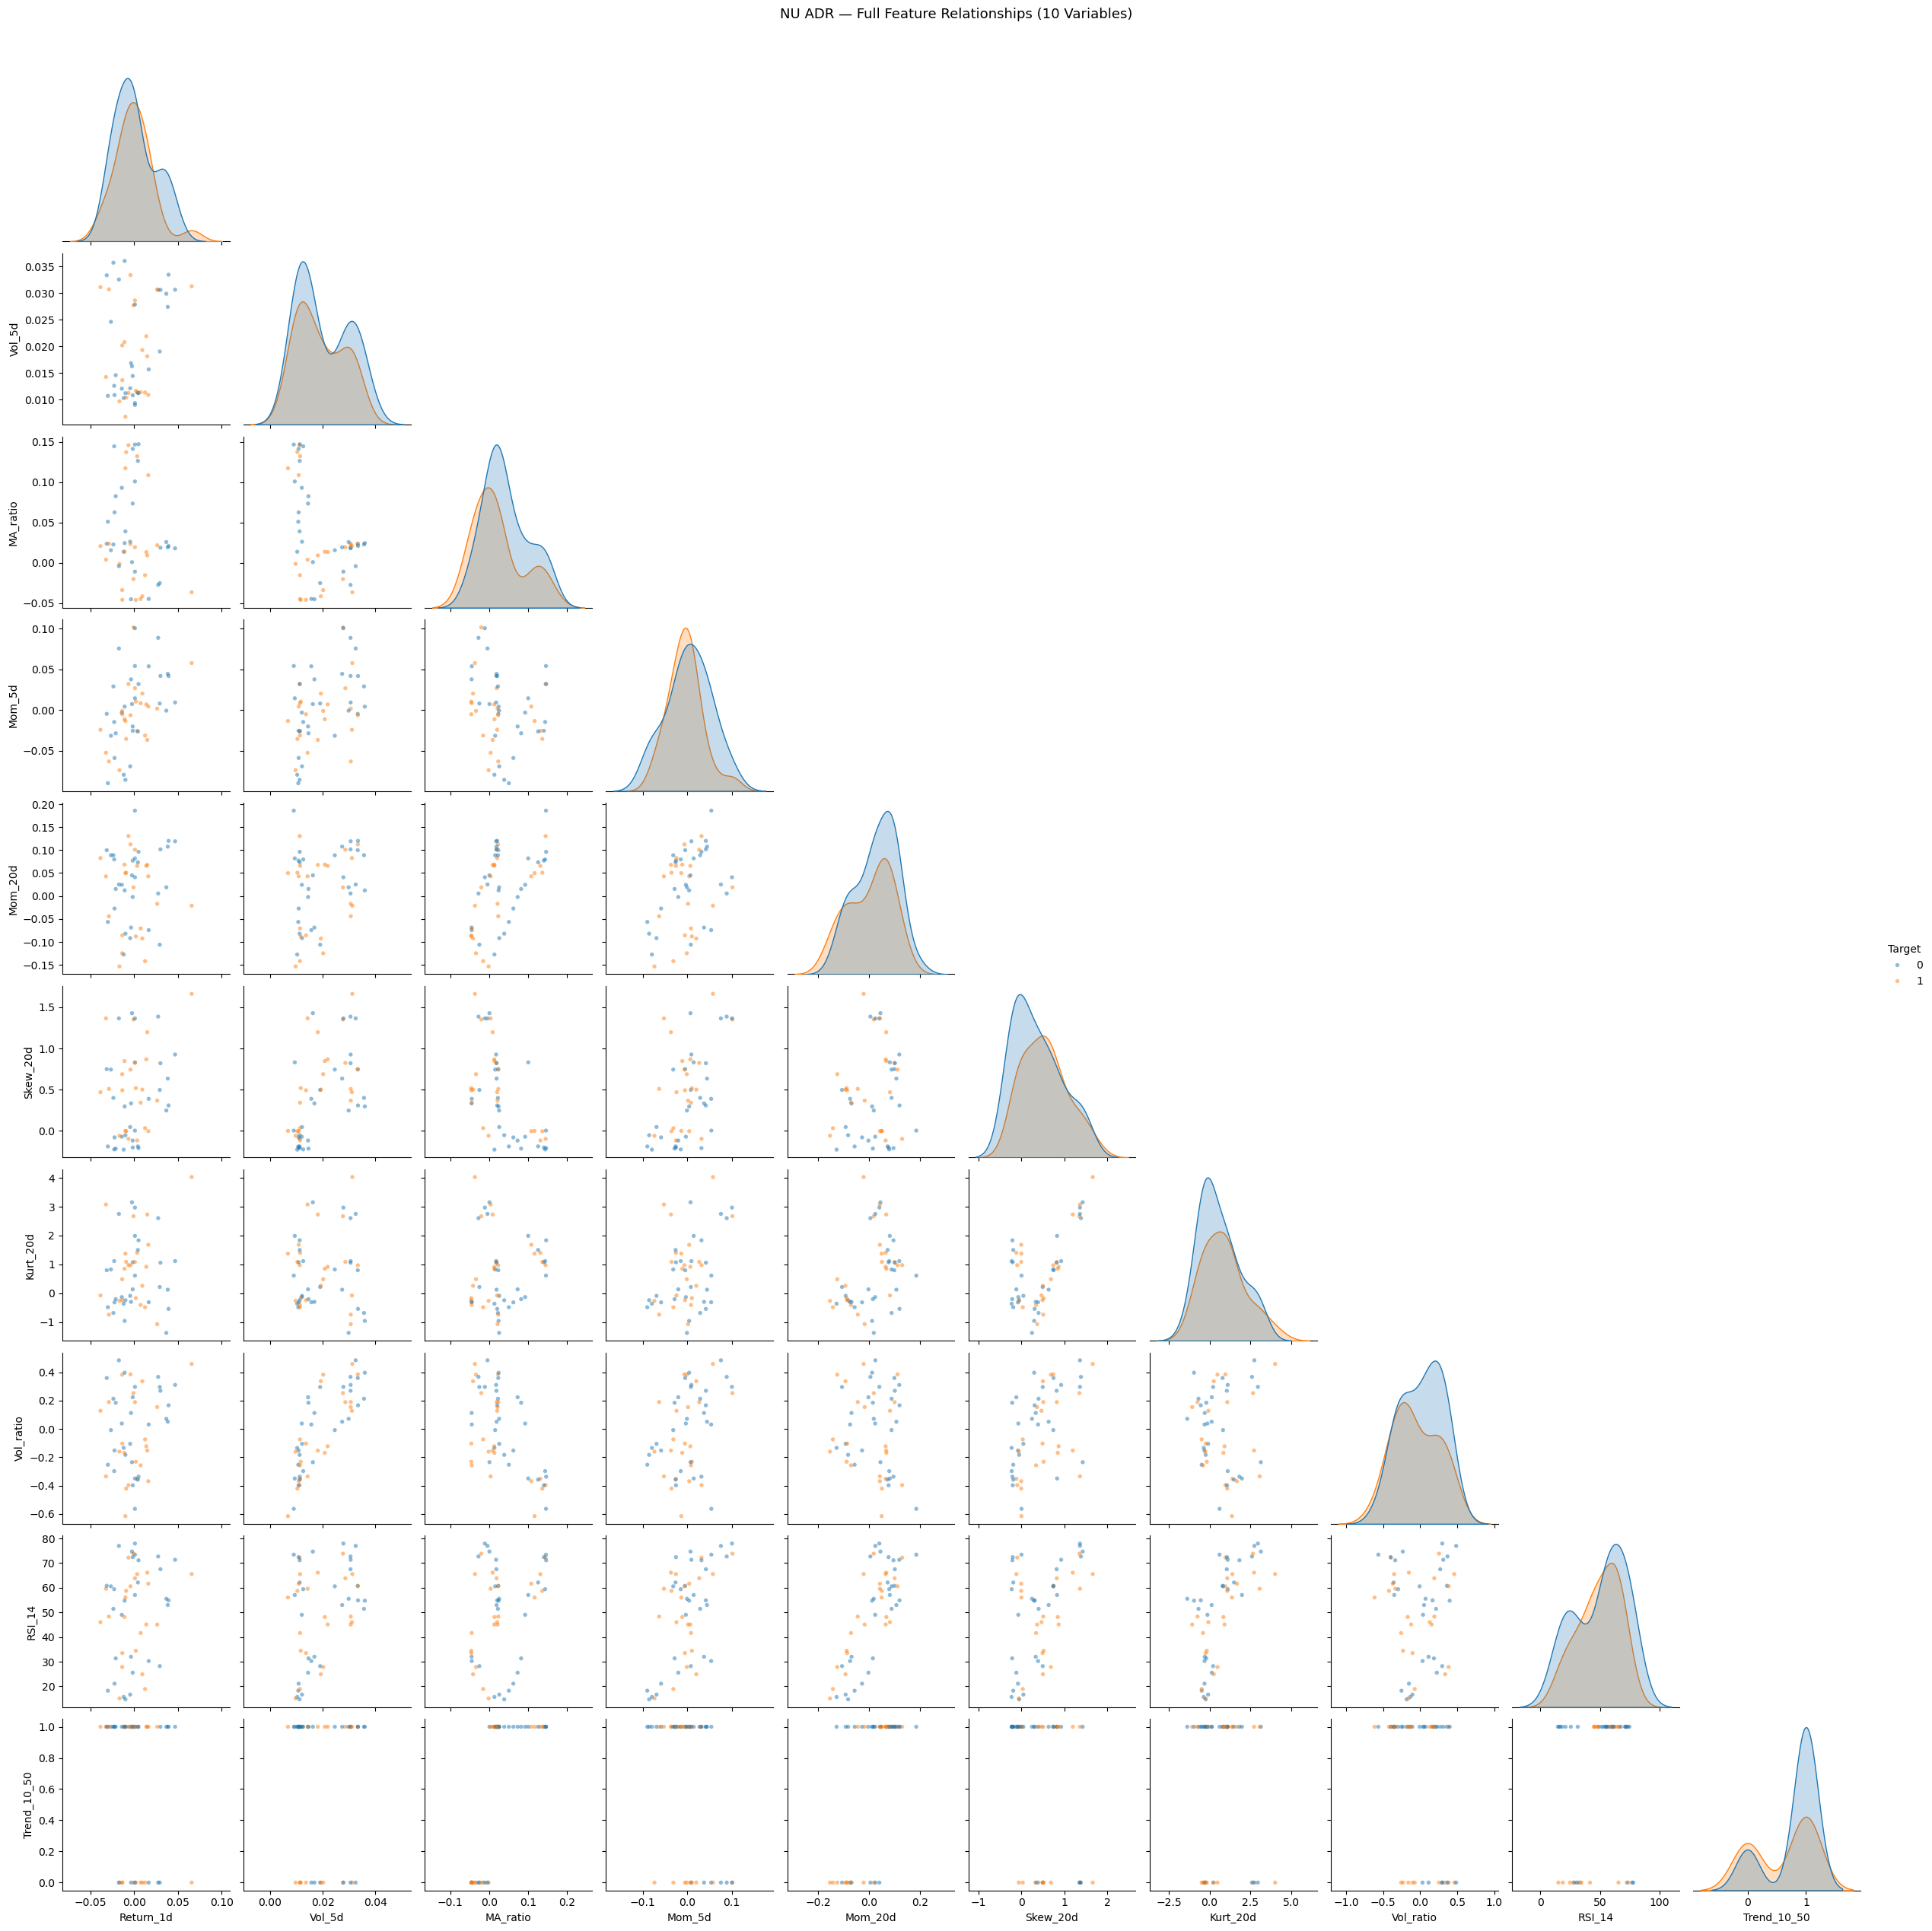

In [3]:
# ==============================================================
# Pairplot — Full Feature Relationships (NU ADR)
# =============================================================
# --- Select all engineered features ---
all_features = [
    "Return_1d", "Vol_5d", "MA_ratio", "Mom_5d", "Mom_20d",
    "Skew_20d", "Kurt_20d", "Vol_ratio", "RSI_14", "Trend_10_50"
]

# --- Subsample if needed (to make plot manageable) ---
# Optional: if you have thousands of rows, uncomment the line below
# df_sample = df.sample(300, random_state=42)
# else just use df directly
df_sample = df.copy()

# --- Create pairplot ---
sns.pairplot(
    df_sample,
    vars=all_features,
    hue="Target",
    diag_kind="kde",
    corner=True,  # show only lower triangle to avoid clutter
    plot_kws={'alpha': 0.5, 's': 15, 'edgecolor': 'none'}
)

plt.suptitle("NU ADR — Full Feature Relationships (10 Variables)", y=1.02, fontsize=13)
plt.show()

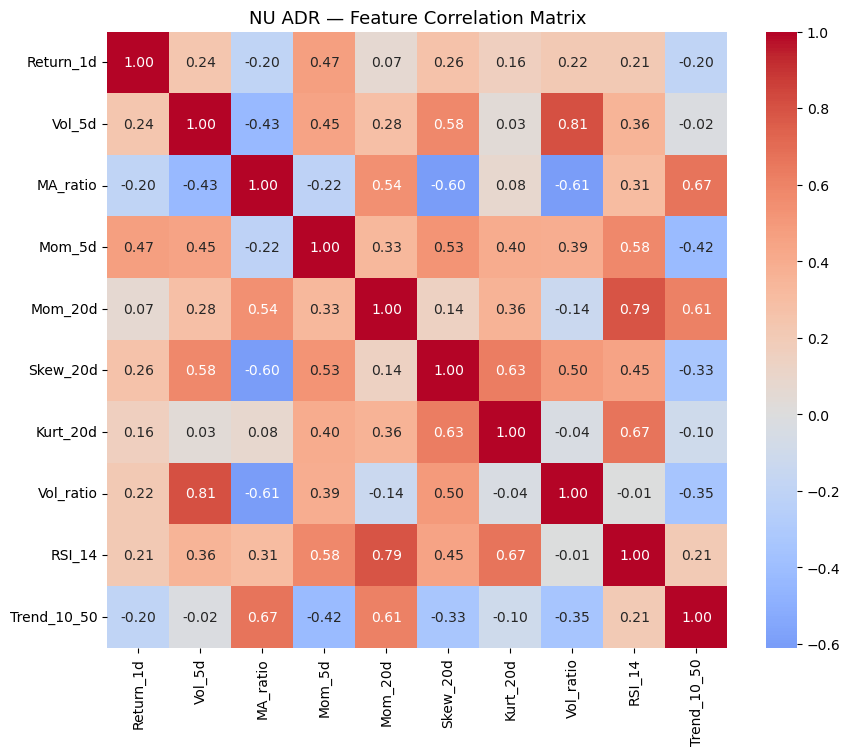

In [4]:
plt.figure(figsize=(10, 8))
corr = df[all_features].corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", center=0)
plt.title("NU ADR — Feature Correlation Matrix", fontsize=13)
plt.show()

### 4. Logistic Regression Pipeline

Train Accuracy: 0.643
Test  Accuracy: 0.455


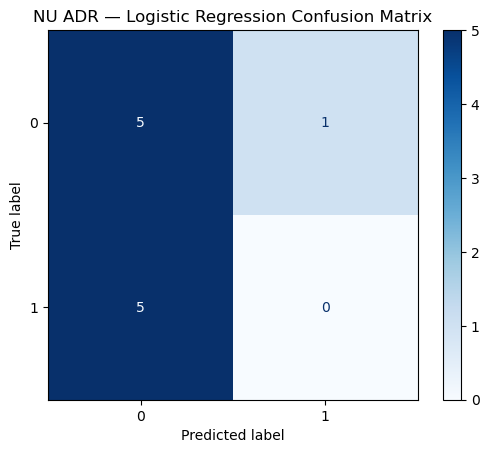

              precision    recall  f1-score   support

           0      0.500     0.833     0.625         6
           1      0.000     0.000     0.000         5

    accuracy                          0.455        11
   macro avg      0.250     0.417     0.312        11
weighted avg      0.273     0.455     0.341        11



In [5]:
# ==============================================================
# 4. Logistic Regression Pipeline — Predicting Next-Day Direction
# ==============================================================

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# --- Features & Target ---
features = [
    "Return_1d", "Vol_5d", "MA_ratio", "Mom_5d", "Mom_20d",
    "Skew_20d", "Kurt_20d", "Vol_ratio", "RSI_14", "Trend_10_50"
]
X = df[features]
y = df["Target"].values

# --- Chronological Split (80 / 20) ---
split = int(0.8 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y[:split], y[split:]

# --- Pipeline: Standardization + Logistic Regression ---
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight="balanced")
)
pipe.fit(X_train, y_train)

# --- Evaluate ---
train_acc = pipe.score(X_train, y_train)
test_acc  = pipe.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test  Accuracy: {test_acc:.3f}")

# --- Confusion Matrix ---
ConfusionMatrixDisplay(confusion_matrix(y_test, pipe.predict(X_test))).plot(cmap="Blues")
plt.title("NU ADR — Logistic Regression Confusion Matrix")
plt.show()

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

### 5. Logistic Decision Boundary (Optional Visualization)

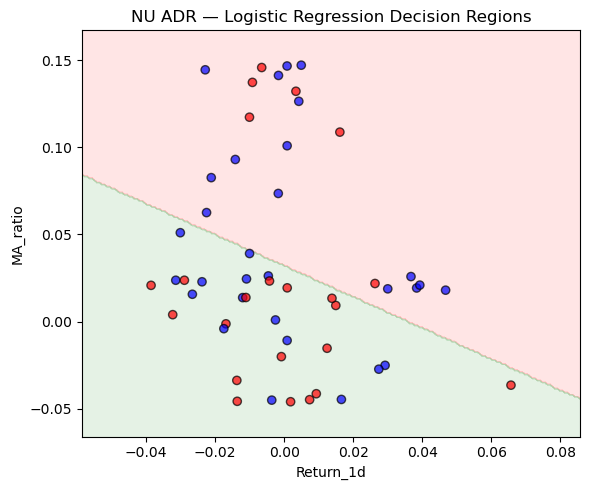

In [6]:
# ==============================================================
# 5. Logistic Regression Decision Boundary (NU ADR)
# ==============================================================

from matplotlib.colors import ListedColormap

# --- Select two features for visualization ---
feat1, feat2 = "Return_1d", "MA_ratio"
X2 = df[[feat1, feat2]].values
y2 = df["Target"].values

# --- Train pipeline (scaled logistic regression) ---
pipe2 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight="balanced"))
pipe2.fit(X2, y2)

# --- Mesh grid over feature space ---
x_min, x_max = X2[:, 0].min() - 0.02, X2[:, 0].max() + 0.02
y_min, y_max = X2[:, 1].min() - 0.02, X2[:, 1].max() + 0.02
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = pipe2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# --- Plot decision boundary and observations ---
plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.25, cmap=ListedColormap(["#FF9999", "#99CC99"]))
plt.scatter(X2[:, 0], X2[:, 1], c=y2, edgecolors='k', cmap="bwr", alpha=0.7)
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title("NU ADR — Logistic Regression Decision Regions")
plt.tight_layout()
plt.show()

###  Challenge 1: k-Fold Cross-Validation

In [7]:
# ==============================================================
# Chapter 2 – Challenge 1: k-Fold Cross-Validation (NU ADR)
# ==============================================================

from sklearn.model_selection import KFold, cross_val_score

# --- Feature Matrix & Target ---
X = df[[
    "Return_1d", "Vol_5d", "MA_ratio", "Mom_5d", "Mom_20d",
    "Skew_20d", "Kurt_20d", "Vol_ratio", "RSI_14", "Trend_10_50"
]].values
y = df["Target"].values

# --- Model Pipeline ---
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, class_weight="balanced")
)

# --- 5-Fold Cross Validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X, y, cv=kf, scoring="accuracy")

print("=== Logistic Regression 5-Fold CV Results ===")
print(f"Fold Accuracies : {cv_scores.round(3)}")
print(f"Mean Accuracy   : {cv_scores.mean():.3f}")
print(f"Std Deviation   : {cv_scores.std():.3f}")

=== Logistic Regression 5-Fold CV Results ===
Fold Accuracies : [0.727 0.636 0.455 0.6   0.5  ]
Mean Accuracy   : 0.584
Std Deviation   : 0.097


###  Challenge 2: 2D Decision Boundary Visualization

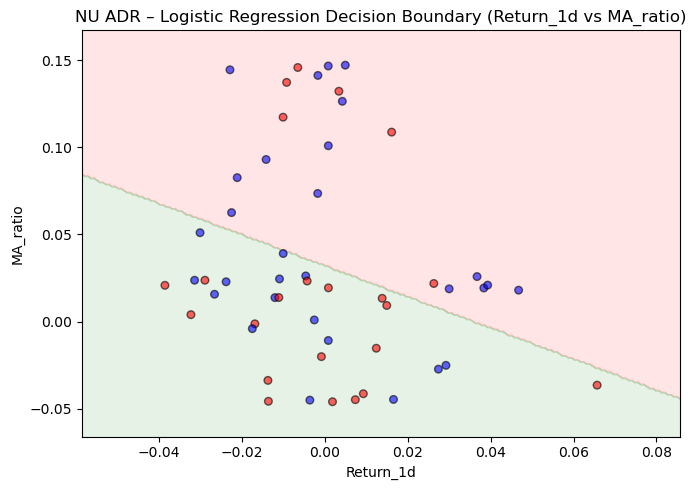

In [8]:
# ==============================================================
# Chapter 2 – Challenge 2: 2D Decision Boundary Visualization (NU ADR)
# ==============================================================

# --- Choose two features for visualization ---
feat1, feat2 = "Return_1d", "MA_ratio"
X2 = df[[feat1, feat2]].values
y2 = df["Target"].values

# --- Standardization + Logistic Regression pipeline ---
pipe2 = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, class_weight="balanced")
)
pipe2.fit(X2, y2)

# --- Create a meshgrid for decision boundary ---
x_min, x_max = X2[:, 0].min() - 0.02, X2[:, 0].max() + 0.02
y_min, y_max = X2[:, 1].min() - 0.02, X2[:, 1].max() + 0.02
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

# --- Predict over the meshgrid ---
Z = pipe2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# --- Plot Decision Regions ---
plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, Z, alpha=0.25, cmap=ListedColormap(["#FF9999", "#99CC99"]))
plt.scatter(X2[:, 0], X2[:, 1], c=y2, edgecolors="k", cmap="bwr", s=30, alpha=0.6)
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title(f"NU ADR – Logistic Regression Decision Boundary ({feat1} vs {feat2})")
plt.tight_layout()
plt.show()

###  Challenge 3: Minimal Data Pipeline API 

In [9]:
# ==============================================================
# Chapter 2 – Challenge 3: Minimal Data Pipeline API (NU ADR)
# ==============================================================

# --- Custom StandardScaler Class ---
class MyScaler:
    """Minimal reimplementation of scikit-learn's StandardScaler."""
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        return self

    def transform(self, X):
        return (X - self.mean_) / (self.std_ + 1e-8)  # avoid division by zero

    def fit_transform(self, X):
        return self.fit(X).transform(X)

# --- Load & Prepare NU ADR Features ---
df = pd.read_csv("../adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "NU"

df["Return_1d"] = df[f"{ticker}_Price"].pct_change()
df["Vol_5d"] = df["Return_1d"].rolling(5).std()
df["MA_10"] = df[f"{ticker}_Price"].rolling(10).mean()
df["MA_50"] = df[f"{ticker}_Price"].rolling(50).mean()
df["MA_ratio"] = df["MA_10"] / df["MA_50"] - 1
df["Target"] = (df["Return_1d"].shift(-1) > 0).astype(int)
df = df.dropna().copy()

# --- Select Features & Split ---
X = df[["Return_1d", "Vol_5d", "MA_ratio"]].values
y = df["Target"].values

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Apply Custom Scaler ---
scaler = MyScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Train Logistic Regression ---
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train_scaled, y_train)

# --- Evaluate ---
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {acc:.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

Test Accuracy: 0.636

Confusion Matrix:
[[6 0]
 [4 1]]

Classification Report:
              precision    recall  f1-score   support

           0      0.600     1.000     0.750         6
           1      1.000     0.200     0.333         5

    accuracy                          0.636        11
   macro avg      0.800     0.600     0.542        11
weighted avg      0.782     0.636     0.561        11



### Summary — Feature Scaling and Linear Decision Boundaries in Financial Data

Feature engineering translated market intuition (volatility, momentum, trend) into statistical predictors.
Scaling was essential for coefficient comparability, exposing redundancy among correlated signals.
The Logistic Regression baseline, though simple, revealed the low signal-to-noise nature of short-horizon ADR returns.
Linear boundaries offer transparency but limited flexibility — motivating the introduction of **regularization** and **non-linear transformations** in upcoming chapters.

> **Key Insight:** In financial ML, preprocessing and scaling often explain more performance gain than model complexity. The next logical extension involves regularization, polynomial expansions, or tree-based methods to capture asymmetric and non-linear dynamics.